In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# This code cell is copied as it is from the tutorial
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
# This code cell is copied as it is from the tutorial
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = r'hymenoptera_data\hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

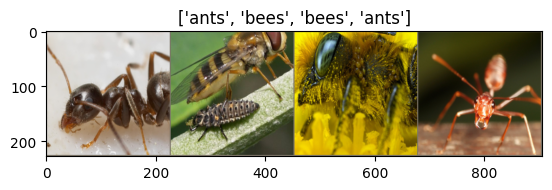

In [4]:
# This code cell is copied as it is from the tutorial
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
# This code cell is copied as it is from the tutorial
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [6]:
# This code cell is copied as it is from the tutorial
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
# This code cell is copied as it is from the tutorial
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [8]:
# This code cell is copied as it is from the tutorial
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7832 Acc: 0.5820
val Loss: 0.2155 Acc: 0.9477

Epoch 1/24
----------
train Loss: 0.5450 Acc: 0.7623
val Loss: 0.1793 Acc: 0.9542

Epoch 2/24
----------
train Loss: 0.4637 Acc: 0.7746
val Loss: 0.1770 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.5351 Acc: 0.7705
val Loss: 0.1900 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.6098 Acc: 0.7541
val Loss: 0.1995 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.3027 Acc: 0.8566
val Loss: 0.2030 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.2978 Acc: 0.8648
val Loss: 0.2300 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.3903 Acc: 0.8443
val Loss: 0.1965 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3730 Acc: 0.8320
val Loss: 0.1903 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.2469 Acc: 0.9016
val Loss: 0.1990 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3898 Acc: 0.8320
val Loss: 0.1830 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.2565 Acc: 0.8770
val Loss: 0.1891 Acc: 0.9477

Ep

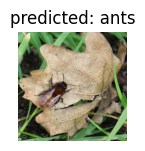

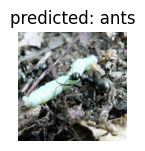

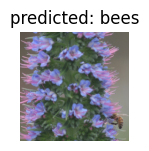

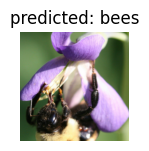

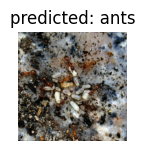

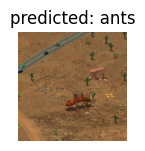

In [9]:
# This code cell is copied as it is from the tutorial
visualize_model(model_conv)

plt.ioff()
plt.show()

In [10]:
# This code cell is copied as it is from the tutorial
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

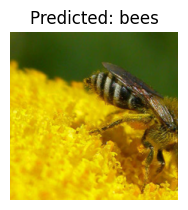

In [11]:
# This code cell is copied as it is from the tutorial
visualize_model_predictions(
    model_conv,
    img_path=r'hymenoptera_data\hymenoptera_data\val\bees\26589803_5ba7000313.jpg'
)

plt.ioff()
plt.show()

In [12]:
def extract_features(model_conv, dataloader):       # Reference (1)
    model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')

    # Remove the last layer
    model_conv = nn.Sequential(*list(model_conv.children())[:-1])

    # Set Model to Evaluation Mode
    model_conv.eval()

    # Extract Features and Labels
    features_list = []
    labels_list = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model_conv(inputs)                # Evaluate model on the input to get outputs
            outputs = outputs.view(outputs.size(0), -1) # Flatten output to (batch size, 512)
            features_list.append(outputs.cpu())         # Append the output to the features list
            labels_list.append(labels)                  # Append the label to the labels list
    
    features = torch.cat(features_list, dim=0)          # Concatenate all features and return as a single array
    labels = torch.cat(labels_list, dim=0)              # Concatenate all labels and return as a single array
    return  features.numpy(), labels.numpy()

In [13]:
# Extract Train features
train_features, train_labels = extract_features(model_conv, dataloaders['train'])
# Print shape of train features and labels
print(f'Train features size: {train_features.shape}')
print(f'Train labels size: {train_labels.shape}')

Train features size: (244, 512)
Train labels size: (244,)


In [14]:
# Extract Val features and labels
val_features, val_labels = extract_features(model_conv, dataloaders['val'])
# Print shape of val features and labels
print(f'Val features size: {val_features.shape}')
print(f'Val labels size: {val_labels.shape}')

Val features size: (153, 512)
Val labels size: (153,)


In [15]:
# Import logistic regression and Random Forest Classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# Import Grid Search Function
from sklearn.model_selection import GridSearchCV
# Import F1 Score from sklearn to evaluate model 
from sklearn.metrics import f1_score

# Define grid for c (inverse of regularisation parameter) 
grid_log = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Define model
model = LogisticRegression(max_iter=1000)       # Reference (2)

# Perform grid search for C
grid_search_log = GridSearchCV(model, grid_log, cv = 5, verbose = 3)

In [16]:
# Fit the best model
grid_search_log.fit(train_features, train_labels)

# Print best hyperparameters
print(f'Best Hyperparameter: {grid_search_log.best_params_}')

# Print train accuracy 
print(f'Best Train Accuracy: {grid_search_log.score(train_features, train_labels)}')

# Print training f1 score
print(f'Best Training F1 Score: {f1_score(train_labels, grid_search_log.predict(train_features))}')

# Print validation accuracy
print(f'Best Validation Accuracy: {grid_search_log.score(val_features, val_labels)}')

# Print validation f1 score
print(f'Best Validation F1 Score: {f1_score(val_labels, grid_search_log.predict(val_features))}')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...........................C=0.001;, score=0.837 total time=   0.0s
[CV 2/5] END ...........................C=0.001;, score=0.939 total time=   0.0s
[CV 3/5] END ...........................C=0.001;, score=0.939 total time=   0.0s
[CV 4/5] END ...........................C=0.001;, score=0.918 total time=   0.0s
[CV 5/5] END ...........................C=0.001;, score=0.979 total time=   0.0s
[CV 1/5] END ............................C=0.01;, score=0.878 total time=   0.0s
[CV 2/5] END ............................C=0.01;, score=0.939 total time=   0.0s
[CV 3/5] END ............................C=0.01;, score=0.939 total time=   0.0s
[CV 4/5] END ............................C=0.01;, score=0.918 total time=   0.0s
[CV 5/5] END ............................C=0.01;, score=0.958 total time=   0.0s
[CV 1/5] END .............................C=0.1;, score=0.878 total time=   0.0s
[CV 2/5] END .............................C=0.1;,

In [17]:
# Define grid for rf
grid_rf = {'max_depth': [5, 10, 20, 50, 100], 'n_estimators': [10, 20, 50, 100, 500]}

# Define model
model = RandomForestClassifier()

# Perform grid search for max_depth and n_estimators
grid_search_rf = GridSearchCV(model, grid_rf, cv = 5, verbose = 3)

In [18]:
# Fit the best model
grid_search_rf.fit(train_features, train_labels)

# Print best hyperparameters
print(f'Best Hyperparameter: {grid_search_rf.best_params_}')

# Print train accuracy 
print(f'Best Train Accuracy: {grid_search_rf.score(train_features, train_labels)}')

# Print training f1 score
print(f'Best Training F1 Score: {f1_score(train_labels, grid_search_rf.predict(train_features))}')

# Print validation accuracy
print(f'Best Validation Accuracy: {grid_search_rf.score(val_features, val_labels)}')

# Print validation f1 score
print(f'Best Validation F1 Score: {f1_score(val_labels, grid_search_rf.predict(val_features))}')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ......max_depth=5, n_estimators=10;, score=0.735 total time=   0.0s
[CV 2/5] END ......max_depth=5, n_estimators=10;, score=0.857 total time=   0.0s
[CV 3/5] END ......max_depth=5, n_estimators=10;, score=0.878 total time=   0.0s
[CV 4/5] END ......max_depth=5, n_estimators=10;, score=0.878 total time=   0.0s
[CV 5/5] END ......max_depth=5, n_estimators=10;, score=0.875 total time=   0.0s
[CV 1/5] END ......max_depth=5, n_estimators=20;, score=0.796 total time=   0.0s
[CV 2/5] END ......max_depth=5, n_estimators=20;, score=0.939 total time=   0.0s
[CV 3/5] END ......max_depth=5, n_estimators=20;, score=0.918 total time=   0.0s
[CV 4/5] END ......max_depth=5, n_estimators=20;, score=0.939 total time=   0.0s
[CV 5/5] END ......max_depth=5, n_estimators=20;, score=0.854 total time=   0.0s
[CV 1/5] END ......max_depth=5, n_estimators=50;, score=0.837 total time=   0.0s
[CV 2/5] END ......max_depth=5, n_estimators=50

# Logistic Regression
### Best Hyperparameter
1. C = 0.1

### Results
1. Best Train Accuracy: 1.0
2. Best Training F1 Score: 1.0
3. Best Validation Accuracy: 0.961
4. Best Validation F1 Score: 0.964

# Random Forest Classification
### Best Hyperparameters
1. Max Depth = 20
2. Number of Estimators = 500

### Results
1. Best Train Accuracy: 1.0
2. Best Training F1 Score: 1.0
3. Best Validation Accuracy: 0.941
4. Best Validation F1 Score: 0.945

## Observations
The Logistic Regression model performs sligthly better on this dataset compared to the Random Forest classifier

## References
1. ChatGPT:- Extract features from a pretrained ResNet18 model
2. Sklearn Documentation for regularisation in Logistic Regression